# Real Box Office Data Analysis

This project analyzes a set of real box office data (provided by flatiron data science school) which includes information gathered from Box Office Mojo, IMDB, Rotten Tomatoes, ThemovieDB, and The Numbers in order to provide business insights for the investors looking to open a new movie studio.

## Data explaination

The data files used for the analysis are not included within this repository in order to reflect industry best practicies and to simulate the process I would follow if I were working with private and sensitive data. The zipped data can be obtained at the flatiron school repository which served as a model example for this project, accessible [here.](https://github.com/learn-co-curriculum/dsc-phase-2-project-v3/tree/gating/zippedData)

## Introduction

The purpose of this project is to create actionable, data-based reccommendations that the investors in a new movie studio can follow in order to maximize the success of their new films. For the purpose of this analysis, I am considering 'success' to be the profitability an degree of profitability of the movie; not just positive user ratings. In my exploratory analysis of the data, I found that there was a correlation between the budget of the movie and the user ratings the movie recieved, and I additionally found a correlation between user ratings and the total profit of the movie. I also found the number of total foreign markets a movie was released in to be a strong predictor of the movie's profit. Finally, I found that the original language the movie was produced in to be another strong predictor of success.

## Data Assembly and Cleaning

In my exploratory analysis, I found that out of the five sources of data I have assembled for the project, only three of them were well suited to my analysis. The Box Office Mojo data is an inferior version of the data from The Numbers, and joining the Rotten Tomatoes data with everything else would result in a huge amount of lost entries/NaN values, meaning it was not feasible to include it. In the cells below, I assemble the data into a single dataframe and clean out the missing and placeholder values from the columns I plan to use in my analysis.

In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import seaborn as sns
from pandasql import sqldf
from scipy import stats

In [2]:
# Load TMDB data
tmdbdf = pd.read_csv("data/tmdb.movies.csv")
# Trim columns from TMDB data that are not useful for this analysis, reformat data to be easier to work with
tmdbdf.drop(columns=['id', 'Unnamed: 0', 'genre_ids', 'release_date'], inplace=True)
tmdbdf.columns = ['original_language', 'original_title', 'popularity', 'title', 'TMDBvote_average', 'TMDBvote_count']
tmdbdf.set_index('original_title', inplace=True)

# Load data from The Numbers
tndf = pd.read_csv("data/tn.movie_budgets.csv")
# Same trimming process as above
tndf.drop(columns='id', inplace=True)
tndf.set_index('movie', inplace=True)

# Set up connection to IMDB SQL database
conn = sqlite3.connect('data/im.db')

# Query SQL database for IMDB ratings and number of regions movies were released in
q = """
SELECT primary_title, averagerating AS IMDBrating, numvotes AS IMDBnumvotes, COUNT(DISTINCT region) AS num_markets
  FROM movie_basics as MB
  JOIN movie_ratings as MR
      USING(movie_id)
  JOIN movie_akas
      USING(movie_id)
GROUP BY primary_title
"""
imdbdf = pd.read_sql(q, conn)
imdbdf.set_index('primary_title', inplace=True)

# Join dataframes together to create the main source of data I will use in this analysis
fulldf = tndf.join([tmdbdf, imdbdf], how='inner')

# Trim out a duplicate column, calculate a new profit column, and then drop the now-redundant columns that were used to calculate it
# Remove the dollar signs and commas, then convert data type to integer
fulldf['worldwide_gross'] = fulldf['worldwide_gross'].map(lambda x: int(x.replace(",", "")[1:]))
fulldf['production_budget'] = fulldf['production_budget'].map(lambda x: int(x.replace(",", "")[1:]))
# Calculate the new profit column: worldwide gross - production budget
fulldf['profit'] = fulldf['worldwide_gross'] - fulldf['production_budget'] 
fulldf.drop(columns=['domestic_gross', 'worldwide_gross', 'title'], inplace=True)
fulldf.head()

,release_date,production_budget,original_language,popularity,TMDBvote_average,TMDBvote_count,IMDBrating,IMDBnumvotes,num_markets,profit
#Horror,"Nov 20, 2015",1500000,de,6.099,3.3,102,3.0,3092,3,-1500000
10 Cloverfield Lane,"Mar 11, 2016",5000000,en,17.892,6.9,4629,7.2,260383,25,103286422
10 Days in a Madhouse,"Nov 11, 2015",12000000,en,0.955,5.4,7,6.7,1114,2,-11985384
12 Strong,"Jan 19, 2018",35000000,en,13.183,5.6,1312,6.6,50155,26,36118378
12 Years a Slave,"Oct 18, 2013",20000000,en,16.493,7.9,6631,8.1,577301,32,161025343


All of the programming that was used to create this dataframe was taken from the exploration branch of this repository, where I did my exploratory analysis. Now that I have the data I want to use in a workable format, I need to check for missing values and obvious placeholders.

In [3]:
fulldf.describe()

,production_budget,popularity,TMDBvote_average,TMDBvote_count,IMDBrating,IMDBnumvotes,num_markets,profit
count,2.140000e+03,2140.000000,2140.000000,2140.000000,2140.000000,2.140000e+03,2140.000000,2.140000e+03
mean,3.877142e+07,10.868855,6.206355,1760.184579,6.261075,9.649431e+04,20.400000,8.370660e+07
std,5.249873e+07,8.317120,1.127242,2749.367955,1.103754,1.537298e+05,10.884141,1.865289e+08
min,9.000000e+03,0.600000,0.000000,1.000000,1.600000,5.000000e+00,1.000000,-1.104502e+08
25%,5.000000e+06,5.860250,5.600000,71.000000,5.700000,2.986000e+03,12.000000,-1.500000e+06
50%,2.000000e+07,9.592500,6.300000,675.500000,6.400000,3.874000e+04,23.000000,1.417473e+07
75%,4.800000e+07,14.502750,6.900000,2148.250000,7.000000,1.190545e+05,29.000000,7.918545e+07
max,4.250000e+08,80.773000,10.000000,22186.000000,9.200000,1.841066e+06,48.000000,2.351345e+09


A potential issue with this dataset is the small number of records that I've ended up with. The IMDB database is rather large, but due to the reliance of my analysis on profit as a metric of success, I can only use records that overlap with the data from The Numbers, which is a rather small amount. Regardless, due to the relatively small number of movies that come out each year, this amount of data should be sufficient for this analysis, and later in my analysis I use statistical tests to confirm that this is the case.

In [4]:
fulldf.isna().any()

release_date         False
production_budget    False
original_language    False
popularity           False
TMDBvote_average     False
TMDBvote_count       False
IMDBrating           False
IMDBnumvotes         False
num_markets          False
profit               False
dtype: bool

Thankfully, it looks like there aren't any missing values! Now, I'm going to check the columns that are imortant for my analysis to see if I can spot any obvious placeholder values.

In [5]:
fulldf['production_budget'].value_counts().head(10)

10000000    95
20000000    87
5000000     76
25000000    71
30000000    68
40000000    57
15000000    54
35000000    53
2000000     48
12000000    47
Name: production_budget, dtype: int64

It looks like the values in production budget have been rounded into bins by tens of millions of dollars, but nothing here immediately jumps out as a placeholder (I would expect something like $0).

In [6]:
fulldf['TMDBvote_average'].value_counts().head(10)

6.2    99
5.9    98
6.0    98
6.1    96
6.6    91
6.7    90
5.8    90
6.3    89
6.8    86
6.5    78
Name: TMDBvote_average, dtype: int64

In [7]:
fulldf['IMDBrating'].value_counts().head(10)

6.4    98
6.6    95
6.5    93
6.3    91
6.2    88
6.7    79
6.8    78
7.1    77
7.2    75
6.1    73
Name: IMDBrating, dtype: int64

Neither of my rating aggregate columns seem to have obvious placeholder values either, which is good. I just need to check the number of markets column and original language columns now.

In [8]:
fulldf['num_markets'].value_counts().head(10)

29    114
26    105
27     93
1      87
28     82
24     80
2      79
30     75
25     72
23     71
Name: num_markets, dtype: int64

This is also looking perfect.

In [9]:
fulldf['original_language'].value_counts()

en    2092
fr      13
es       8
hi       4
de       4
ko       2
et       2
ar       2
xx       1
th       1
gu       1
pt       1
ur       1
tl       1
pl       1
fa       1
te       1
it       1
tr       1
fi       1
da       1
Name: original_language, dtype: int64

For the analysis I plan to do on this column, having a large number of original languages with only one movie is completely unacceptable. My solution to this is going to be to drop the original languages that have less than four entries to ensure that there is at least a reasonable spread of values within each. I don't want to prune out rows from the main dataframe either due to its already limited size, so I am going to create a separate dataframe with these changes.

In [10]:
langdf = fulldf[fulldf.groupby('original_language').original_language.transform('count')>3].copy() 
langdf['original_language'].value_counts()

en    2092
fr      13
es       8
de       4
hi       4
Name: original_language, dtype: int64

The code I used to make that change was taken from [this incredibly helpful Stack Overflow page.](https://stackoverflow.com/questions/49735683/python-removing-rows-on-count-condition)

I also want to simplify the ratings columns by combining the ratings from both sources together using a weighted average, based on the total number of reviews from each source. This shouldn't be too difficult for me to do.

In [11]:
# Calculate the total number of reviews each movie recieved
fulldf['total_num_reviews'] = fulldf['TMDBvote_count'] + fulldf['IMDBnumvotes']\

# Calculate the number of reviews that were from IMDB or TMDB as a percentage
fulldf['TMDB_percentage'] = fulldf['TMDBvote_count'] / fulldf['total_num_reviews']
fulldf['IMDB_percentage'] = fulldf['IMDBnumvotes'] / fulldf['total_num_reviews']

# Calculate the weighted average by multiplying the aggregate score from each source by the source's percentage of votes and adding them together
fulldf['aggregate_score'] = (fulldf['TMDB_percentage'] * fulldf['TMDBvote_average']) + (fulldf['IMDB_percentage'] * fulldf['IMDBrating'])

# Display the result
fulldf['aggregate_score']

#Horror                       3.009580
10 Cloverfield Lane           7.194760
10 Days in a Madhouse         6.691882
12 Strong                     6.574508
12 Years a Slave              8.097729
                                ...   
Zookeeper                     5.201663
Zoolander 2                   4.700000
Zoom                          6.089096
Zootopia                      7.992392
xXx: Return of Xander Cage    5.212195
Name: aggregate_score, Length: 2140, dtype: float64

I am happy with this result, so I am going to drop the extra columns I just created and the original columns that contained the aggregate scores and score counts to make the final dataframe much easier to read.

In [12]:
fulldf.drop(columns=['TMDB_percentage', 'IMDB_percentage', 'total_num_reviews', 'TMDBvote_count', 'IMDBnumvotes', 'TMDBvote_average', 'IMDBrating'], inplace=True)
fulldf

,release_date,production_budget,original_language,popularity,num_markets,profit,aggregate_score
#Horror,"Nov 20, 2015",1500000,de,6.099,3,-1500000,3.009580
10 Cloverfield Lane,"Mar 11, 2016",5000000,en,17.892,25,103286422,7.194760
10 Days in a Madhouse,"Nov 11, 2015",12000000,en,0.955,2,-11985384,6.691882
12 Strong,"Jan 19, 2018",35000000,en,13.183,26,36118378,6.574508
12 Years a Slave,"Oct 18, 2013",20000000,en,16.493,32,161025343,8.097729
...,...,...,...,...,...,...,...
Zookeeper,"Jul 8, 2011",80000000,en,10.764,30,90805525,5.201663
Zoolander 2,"Feb 12, 2016",50000000,en,12.997,17,5348693,4.700000
Zoom,"Aug 11, 2006",35000000,en,3.434,7,-22493812,6.089096
Zootopia,"Mar 4, 2016",150000000,en,27.549,45,869429616,7.992392


## Analysis

### Budget vs. Aggregate Score

The first step in my analysis is to establish the correlation between production budget and average aggregate score of the films. I plan to do this with a scatter plot and a simple linear regression model.

In [37]:
# Import statsmodels to create a linear regression model, set seaborn style
import statsmodels.api as sm
plt.style.use('seaborn-whitegrid')

                            OLS Regression Results                            
Dep. Variable:        aggregate_score   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     87.22
Date:                Fri, 25 Aug 2023   Prob (F-statistic):           2.36e-20
Time:                        12:40:11   Log-Likelihood:                -3114.7
No. Observations:                2140   AIC:                             6233.
Df Residuals:                    2138   BIC:                             6245.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.1114      0.02

In [ ]:
# Create regression model and display the summary of results
BSmodel = sm.OLS(endog = fulldf['aggregate_score'], exog = sm.add_constant(fulldf['production_budget']))
BSresults = BSmodel.fit()
print(BSresults.summary())

There's quite a bit of interpretation I can do with these results. First of all, this model predicts that even with a budget of 0 dollars, you will expect the minimum average score your movie will recieve to be 6.1114. The slope of the line can be interpreted to mean that for every $1,000,000 of production budget, on average, the aggregate score of the movie will increase by 0.004. This doesn't mean that spending more money on production is guaranteed to get you higher reviews, but it does mean that we expect that to happen on average, and it does establish a correlation between the two.

The p-statistics of the coefficients and the entire model are extremely low, meaning that essentially no matter what alpha value we may have chosen, the model will still be considered statistically significant. It is very unlikely that this prediction is simply due to sampling error, and it is much more likely that there really is some effect that is causing movies with higher production values to get better reviews.

Now, I will plot the linear regression like to show this result visually.

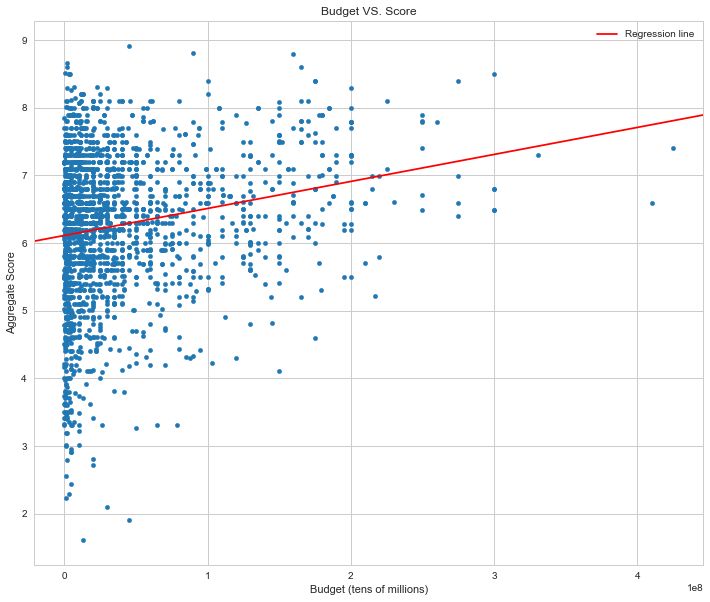

In [40]:
fig, ax1 = plt.subplots(figsize=(12,10))
fulldf.plot.scatter(x='production_budget', y='aggregate_score', ax=ax1)
ax1.set_title('Budget VS. Score')
ax1.set_xlabel('Budget (tens of millions)')
ax1.set_ylabel('Aggregate Score')
sm.graphics.abline_plot(model_results=BSresults, label='Regression line', ax=ax1, color='red')
ax1.legend();

Visually inspecting this graph, it is apparent that a logarithmic graph would likely fit the data slightly better than a simple linear model. However, I think this result is sufficient to establish the correlation I'm looking to prove - I could do an analysis of the residuals to show that a log transformation would make the model more accurate, but because this is an intermediate step in proving a more important connection, I'm going to leave it here.

### Aggregate Score vs. Profit

High user ratings are not the only metric of a movie's success: in fact, profit is much more interesting to investors who want to open a movie studio. For this reason, I also need to establish a correlation between the aggregate rating a movie recieves and the total profit it made.

In [41]:
ASPDmodel = sm.OLS(endog = fulldf['profit'], exog = sm.add_constant(fulldf['aggregate_score']))
ASPDresults = ASPDmodel.fit()
print(ASPDresults.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     145.9
Date:                Fri, 25 Aug 2023   Prob (F-statistic):           1.56e-32
Time:                        12:53:03   Log-Likelihood:                -43720.
No. Observations:                2140   AIC:                         8.744e+04
Df Residuals:                    2138   BIC:                         8.745e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.954e+08   2.34e+07     

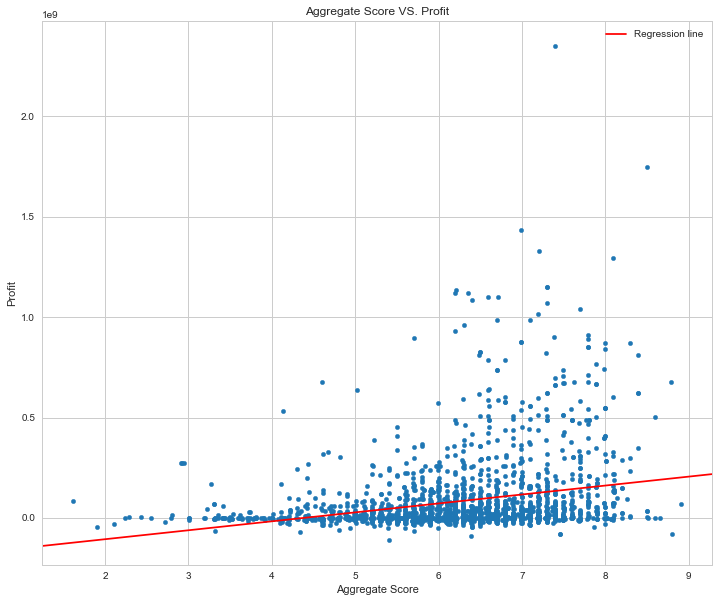

In [43]:
fig, ax2 = plt.subplots(figsize=(12,10))
fulldf.plot.scatter(x='aggregate_score', y='profit', ax=ax2)
ax2.set_title('Aggregate Score VS. Profit')
ax2.set_xlabel('Aggregate Score')
ax2.set_ylabel('Profit')
sm.graphics.abline_plot(model_results=ASPDresults, label='Regression line', ax=ax2, color='red')
ax2.legend();